In [1]:
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.nn as dglnn
from dgl import from_networkx
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# this dataset will crash the kernel if loaded fully, so we need to load a sampled version of it
# data = pd.read_csv('data/NF-UNSW-NB15-v3.csv')
# # drop data with NaN or inf values
# data.replace([np.inf, -np.inf], np.nan, inplace=True)
# data = data.dropna()
# data.reset_index(drop=True, inplace=True)

In [ ]:
from data_cleaning import clean_nfunsw_nb15

# load this dataset and clean it
data = pd.read_csv('data/NF-UNSW-NB15-v3.csv')

data = clean_nfunsw_nb15(data)

In [ ]:
""" # Sample 10% of the data, stratified by 'label' to validate the algorithm. keep category distribution
# Our dataset if loaded fully is too large for graph construction to fit in memory and crashes the kernel
sampled_data, _ = train_test_split(
    data,
    test_size=0.85,  # Keep 15%
    stratify=data['Attack'],
    random_state=42
)

# Use sampled_data for the rest of the notebook
data = sampled_data """

In [ ]:
data.head()

,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,...,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Label,Attack
1004985,1424245625568,1424245625642,59.166.0.4,8189,149.171.126.0,42179,6,36.0,2542,40,...,0,11,1,2,0,12,1,2,0,Benign
54958,1424242567463,1424242567686,59.166.0.1,56869,149.171.126.7,38587,6,0.0,424,8,...,0,175,31,60,0,175,20,50,0,Benign
1217895,1421930291962,1421930291967,59.166.0.2,22543,149.171.126.4,5190,6,0.0,1920,22,...,0,1,0,0,0,1,0,0,0,Benign
1600660,1421946059493,1421946059558,59.166.0.9,13218,149.171.126.2,65034,6,37.0,320,6,...,0,64,12,25,0,64,9,22,0,Benign
421652,1424252914993,1424252914995,59.166.0.7,24669,149.171.126.8,21,6,37.0,261,5,...,0,1,0,0,0,1,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987057,1424219999936,1424219999950,59.166.0.7,16523,149.171.126.5,6881,6,37.0,1540,16,...,0,5,0,1,0,4,0,1,0,Benign
2226736,1421972055948,1421972055989,59.166.0.1,47159,149.171.126.8,18029,6,36.0,3598,60,...,0,3,0,0,0,4,0,0,0,Benign
66127,1424255069620,1424255069698,59.166.0.0,56946,149.171.126.2,23576,6,36.0,3390,56,...,0,13,1,2,0,13,1,2,0,Benign
1421626,1421938583030,1421938592393,59.166.0.6,18196,149.171.126.0,21,6,1.0,2059,37,...,0,1311,239,341,0,1578,248,363,0,Benign


In [ ]:
# anonymize IP addresses by replacing them with random private IPs in the range
#data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [ ]:
# convert IP addresses and ports to string type then concatenate them to form unique node identifiers
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)
data.info()
data.head()

In [ ]:
# we don't need the Label column as we are doing multiclass classification
data.drop(columns=['Label'],inplace = True)

In [11]:
data.rename(columns={"Attack": "label"},inplace = True)

## Chronological split of data to 60/30/10

In [ ]:
from chronological_split import (
    make_chronological_split_indices,
    save_split_indices, load_split_indices,
    save_split_frames,
)

# df_clean = ...  # output of your data_cleaning.clean_nfunsw_nb15(df_raw)

# 1) Create indices (once)
train_idx, val_idx, test_idx, meta = make_chronological_split_indices(
    data,
    start_col="FLOW_START_MILLISECONDS",  # in ms
    end_col="FLOW_END_MILLISECONDS",
    dur_col="FLOW_DURATION_MILLISECONDS",
    train_ratio=0.60, val_ratio=0.30, test_ratio=0.10, #change to other ratios if needed
)

# 2) Persist indices for future runs
save_split_indices("artifacts/splits", train_idx, val_idx, test_idx, meta)

# (Optional) also dump the materialized split datasets now for reuse
save_split_frames(data, train_idx, val_idx, test_idx, out_dir="artifacts/splits", fmt="parquet")

# 3) In any future run (graph build, feature store, training), load the SAME indices:
train_idx2, val_idx2, test_idx2, meta2 = load_split_indices("artifacts/splits")

# Use them to subset clean dataframe (data) deterministically
df_train = data.loc[train_idx2]
df_val   = data.loc[val_idx2]
df_test  = data.loc[test_idx2]

## Label encoding

In [ ]:
from label_mapping import fit_label_map, transform_labels, save_label_map, load_label_map, class_weights_from_train

# 1) Fit mapping on TRAIN ONLY
label2id = fit_label_map(df_train["label"], order="alpha")  # or order="freq"
save_label_map("artifacts/label_map.json", label2id)

# 2) Apply mapping to all splits (consistent)
label2id = load_label_map("artifacts/label_map.json")
y_train = transform_labels(df_train["label"], label2id)  # np.int64
y_val   = transform_labels(df_val["label"], label2id)
y_test  = transform_labels(df_test["label"], label2id)

# (Optional) sanity check: ensure no -1 slipped in
assert (y_train >= 0).all(), "Train split has unseen/missing labels."

# 3) Class weights for loss
weights = class_weights_from_train(y_train, num_classes=len(label2id))

## Numerical transformation
### Remove highly corelated features
This function visualise correlation between given features.
Also performs log1p, scaler, zero-variance drop, optional Spearman prune on numericals
Applies transformation to test and validation

In [ ]:
from feature_numeric import fit_numeric_transform, transform_numeric

# 0) Columns to EXCLUDE here because they’re numeric-coded categoricals:
numeric_cats = [
    "PROTOCOL", "L7_PROTO",
    "ICMP_TYPE", "ICMP_IPV4_TYPE",
    "DNS_QUERY_TYPE", "DNS_QUERY_ID",
    "FTP_COMMAND_RET_CODE",
    # any other *_TYPE / *_ID style columns you want one-hot later
]

# 1) Correlation heatmap (pre-pruning) on TRAIN only
viz_info = plot_numeric_corr_heatmap(
    df_train,
    exclude_numeric_categoricals=numeric_cats,
    out_dir="artifacts/corr",
    threshold=0.995,         # same ballpark as your pruning threshold
    max_features=150,        # avoid unreadable giant plots
    nonneg_frac=0.995,       # infer nonnegative cols for log1p
    topk_pairs=100,
    filename_prefix="spearman_corr_train"
)
print("[corr-viz]", viz_info)

# 2) TRAIN: fit numeric pipeline (log1p, scaler, zero-variance drop, optional Spearman prune)
Xnum_train, num_arts = fit_numeric_transform(
    df_train,
    exclude_numeric_categoricals=numeric_cats,
    scaler_type="standard",           # or "robust" if outliers are extreme
    apply_corr_prune=True,
    corr_threshold=0.995,
    artifacts_dir="artifacts/numeric"
)
print("[numeric] train shape:", Xnum_train.shape)

# 3) VAL/TEST: apply frozen transforms
Xnum_val, _  = transform_numeric(df_val,  artifacts_dir="artifacts/numeric")
Xnum_test, _ = transform_numeric(df_test, artifacts_dir="artifacts/numeric")
print("[numeric] val/test shapes:", Xnum_val.shape, Xnum_test.shape)

## Categorical encoding
fits a OneHotEncoder on TRAIN only (sparse CSR, float32),
handles numeric-coded categoricals (e.g., PROTOCOL, L7_PROTO, *_TYPE, *_ID),
Optionally puts IPv4 ports in buckets, collapses rare categories (by min_freq or top_k) - not used here as we droped IPv4 ports after encoding it to unique hosts with IP addresses

persists artifacts (encoder + per-column metadata) for deterministic transforms,
transforms VAL/TEST,
returns CSR matrices ready to stack with numeric transformation.

In [ ]:
from categorical_encoding import fit_categorical_transform, transform_categorical

# Choose categorical columns (include your numeric-coded categoricals here!)
cat_cols = [
    "PROTOCOL", "L7_PROTO",
    "ICMP_TYPE", "ICMP_IPV4_TYPE",
    "DNS_QUERY_TYPE", "DNS_QUERY_ID",
    "FTP_COMMAND_RET_CODE",
    # If you want ports as categories (after port bucketing):
    # "L4_SRC_PORT", "L4_DST_PORT", # we dropped ports after concatenating them to IP addresses
    # any other *_TYPE / *_ID style columns you want one-hot
]

# 1) TRAIN — fit encoder (optionally collapse rare cats)
Xcat_train, cat_arts = fit_categorical_transform(
    df_train,
    cat_cols=cat_cols,
    use_port_buckets=False,     # buckets ports into IANA groups to avoid huge dims
    min_freq=50,               # collapse categories with <50 occurrences to "__RARE__" (tune as needed)
    top_k=None,                # or e.g., top_k=20 to keep top-20 per column
    artifacts_dir="artifacts/categorical",
)
print("[categorical] train CSR shape:", Xcat_train.shape)

# 2) VAL/TEST — apply frozen encoder
Xcat_val  = transform_categorical(df_val,  artifacts_dir="artifacts/categorical")
Xcat_test = transform_categorical(df_test, artifacts_dir="artifacts/categorical")
print("[categorical] val/test CSR shapes:", Xcat_val.shape, Xcat_test.shape)


In [17]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,FTP_COMMAND_RET_CODE,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,label
1004985,172.24.169.46:8189,149.171.126.0:42179,6,36.0,2542,40,21294,42,27,27,...,0,0,11,1,2,0,12,1,2,2
54958,172.16.100.144:56869,149.171.126.7:38587,6,0.0,424,8,8824,12,27,19,...,0,0,175,31,60,0,175,20,50,2
1217895,172.26.210.58:22543,149.171.126.4:5190,6,0.0,1920,22,4312,24,27,27,...,0,0,1,0,0,0,1,0,0,2
1600660,172.21.66.173:13218,149.171.126.2:65034,6,37.0,320,6,1850,8,27,19,...,0,0,64,12,25,0,64,9,22,2
421652,172.26.198.81:24669,149.171.126.8:21,6,37.0,261,5,469,7,24,24,...,230,0,1,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987057,172.16.92.193:16523,149.171.126.5:6881,6,37.0,1540,16,1644,18,27,27,...,0,0,5,0,1,0,4,0,1,2
2226736,172.17.32.87:47159,149.171.126.8:18029,6,36.0,3598,60,46456,62,27,27,...,0,0,3,0,0,0,4,0,0,2
66127,172.29.182.15:56946,149.171.126.2:23576,6,36.0,3390,56,43918,58,27,27,...,0,0,13,1,2,0,13,1,2,2
1421626,172.23.139.107:18196,149.171.126.0:21,6,1.0,2059,37,2816,39,24,24,...,125,0,1311,239,341,0,1578,248,363,2


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.3, random_state=123,stratify= label)

In [19]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [20]:
# normalize all columns except the first four and the label column
cols_to_norm = list(set(list(X_train.iloc[:, 4:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [21]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [22]:
X_train

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,label,h
1221276,172.23.111.9:64522,149.171.126.0:22,2.131762,2.001026,0.351717,2.585221,-0.045096,1.558211,-0.160651,0.623160,...,-0.021491,-0.121356,-0.081717,-0.202776,-0.004726,-0.126967,-0.226750,-0.269726,2,"[-0.7139602867659677, -0.466654276834335, -0.6..."
228533,172.16.169.250:59310,149.171.126.1:54711,2.131762,2.000000,-0.029657,0.144036,-0.026177,0.021520,-0.160651,0.623160,...,-0.021491,-0.258317,-0.097495,-0.246594,-0.004726,-0.282082,-0.293895,-0.343191,2,"[-0.14364302774820864, -0.466654276834335, 0.3..."
1457864,172.23.10.249:13328,149.171.126.7:111,2.002875,2.087682,-0.072278,-0.446140,-0.226627,-0.362652,-0.210093,-1.974965,...,-0.021491,-0.266511,-0.093551,-0.252072,-0.004726,-0.289903,-0.277109,-0.343191,2,"[-1.2444879695731854, -0.466654276834335, -0.5..."
704506,172.27.107.137:42061,149.171.126.5:21,2.131762,2.000000,-0.073830,-0.379075,-0.223888,-0.304191,-0.164954,0.334479,...,-0.021491,-0.268852,-0.097495,-0.257549,-0.004726,-0.292510,-0.293895,-0.351354,2,"[0.506253383690633, 2.1876137169262275, -0.214..."
716606,172.30.98.101:1764,149.171.126.6:53,2.002875,2.001039,-0.079804,-0.472966,-0.227464,-0.379355,-0.210093,-1.974965,...,-0.021491,-0.270023,-0.097495,-0.257549,-0.004726,-0.293813,-0.293895,-0.351354,2,"[-1.2444879695731854, -0.466654276834335, -0.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004946,172.30.244.60:51438,149.171.126.6:21,2.131762,2.000000,-0.045689,-0.003508,-0.210972,-0.070347,-0.164954,0.334479,...,-0.021491,-0.266511,-0.097495,-0.257549,-0.004726,-0.291206,-0.293895,-0.351354,2,"[2.0580468559017446, 0.9821819643013432, -0.34..."
1874942,172.17.35.180:59131,149.171.126.3:21290,2.131762,2.000000,-0.035221,0.063558,-0.068753,-0.028589,-0.160651,0.623160,...,-0.021491,-0.267682,-0.097495,-0.257549,-0.004726,-0.291206,-0.293895,-0.351354,2,"[-0.14364302774820864, -0.466654276834335, 2.0..."
139243,172.26.172.79:20000,149.171.126.1:6881,2.131762,2.000000,0.586149,8.540638,10.033089,10.277261,-0.160651,0.623160,...,-0.021491,5.443722,-0.030440,1.067948,-0.004726,6.042446,-0.142819,1.085303,2,"[1.951941319340301, -0.466654276834335, -0.413..."
1085782,172.29.129.189:29860,149.171.126.3:27994,2.131762,2.000000,0.009860,0.707387,0.314040,0.372287,-0.160651,0.623160,...,-0.021491,-0.262999,-0.093551,-0.246594,-0.004726,-0.285992,-0.277109,-0.335029,2,"[0.06856804537467844, -0.466654276834335, 0.24..."


In [23]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [24]:
G = G.to_directed()


In [25]:
G = from_networkx(G,edge_attrs=['h','label'] )


In [26]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [27]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)


In [28]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [29]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [30]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [31]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [32]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [33]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout, num_classes):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, num_classes)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [34]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(G.edata['label'].cpu().numpy()),
                                                 y=G.edata['label'].cpu().numpy())

In [35]:
class_weights = th.FloatTensor(class_weights).cuda()  #- if you have a nvidia GPU
#class_weights = th.FloatTensor(class_weights)
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [36]:
# uncomment if you have a NVIDIA GPU
G = G.to('cuda:0')
G.device

device(type='cuda', index=0)

In [37]:
G.ndata['h'].device


device(type='cuda', index=0)

In [38]:
G.edata['h'].device


device(type='cuda', index=0)

In [39]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']
num_classes = len(np.unique(G.edata['label'].cpu().numpy()))

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2, num_classes).cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,50): # original 8000, maybe too much and will cause out of memory error
    pred = model(G, node_features,edge_features).cuda() #- if you have cuda
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


In [40]:
X_test = encoder.transform(X_test)

In [41]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [42]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,FTP_COMMAND_RET_CODE,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,label
1691135,172.27.242.196:3344,149.171.126.1:53,2.002875,2.001039,-0.079804,-0.472966,-0.227464,-0.379355,-0.210093,-1.974965,...,-0.466654,-0.021491,-0.270023,-0.097495,-0.257549,-0.004726,-0.293813,-0.293895,-0.351354,2
1709946,172.27.168.3:50276,149.171.126.4:63753,2.131762,2.000000,-0.012395,0.385472,0.124819,0.171849,-0.160651,0.623160,...,-0.466654,-0.021491,-0.262999,-0.097495,-0.252072,-0.004726,-0.285992,-0.293895,-0.343191,2
1434858,172.16.227.127:5285,149.171.126.5:80,2.131762,2.290553,-0.052377,-0.312009,-0.165008,-0.245730,-0.160651,0.623160,...,-0.466654,-0.021491,0.899416,0.206226,1.193925,-0.004726,1.009675,0.696490,1.566910,2
515807,172.20.220.67:21122,149.171.126.6:50655,2.131762,2.000000,-0.010826,0.412298,0.148214,0.188552,-0.160651,0.623160,...,-0.466654,-0.021491,-0.264170,-0.097495,-0.252072,-0.004726,-0.287296,-0.293895,-0.343191,2
1528529,172.21.38.199:59511,149.171.126.3:62752,2.131762,2.000000,-0.076701,-0.419314,-0.216861,-0.329246,-0.160651,-0.146655,...,-0.466654,-0.021491,-0.268852,-0.097495,-0.257549,-0.004726,-0.292510,-0.293895,-0.351354,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948763,172.18.88.223:59781,149.171.126.7:22,2.131762,2.001026,-0.015926,-0.070573,-0.193704,-0.178917,-0.160651,0.623160,...,-0.466654,-0.021491,-0.204469,-0.061995,-0.169913,-0.004726,-0.220818,-0.109247,-0.212586,2
1968914,172.21.88.119:29268,149.171.126.2:25,2.131762,2.000000,0.583723,0.197689,-0.207446,-0.045292,-0.160651,0.623160,...,-0.466654,-0.021491,-0.264170,-0.097495,-0.257549,-0.004726,-0.283385,-0.293895,-0.343191,2
1878553,172.22.159.140:47993,149.171.126.0:6881,2.131762,2.000000,-0.054945,-0.285183,-0.218299,-0.245730,-0.160651,0.623160,...,-0.466654,-0.021491,0.001558,0.083949,0.175155,-0.004726,0.071164,0.377553,0.317997,2
1523996,172.20.75.38:33395,149.171.126.4:50797,2.131762,2.000000,-0.018244,0.304994,0.081781,0.121739,-0.160651,0.623160,...,-0.466654,-0.021491,-0.266511,-0.097495,-0.257549,-0.004726,-0.289903,-0.293895,-0.351354,2


In [43]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [44]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [45]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [46]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [47]:
G_test = G_test.to('cuda:0')


In [48]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda() # -if you have cuda
elapsed = timeit.default_timer() - start_time

In [49]:
print(str(elapsed) + ' seconds')


0.007485706126317382 seconds


In [50]:
test_pred = test_pred.argmax(1)


In [51]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [52]:
actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

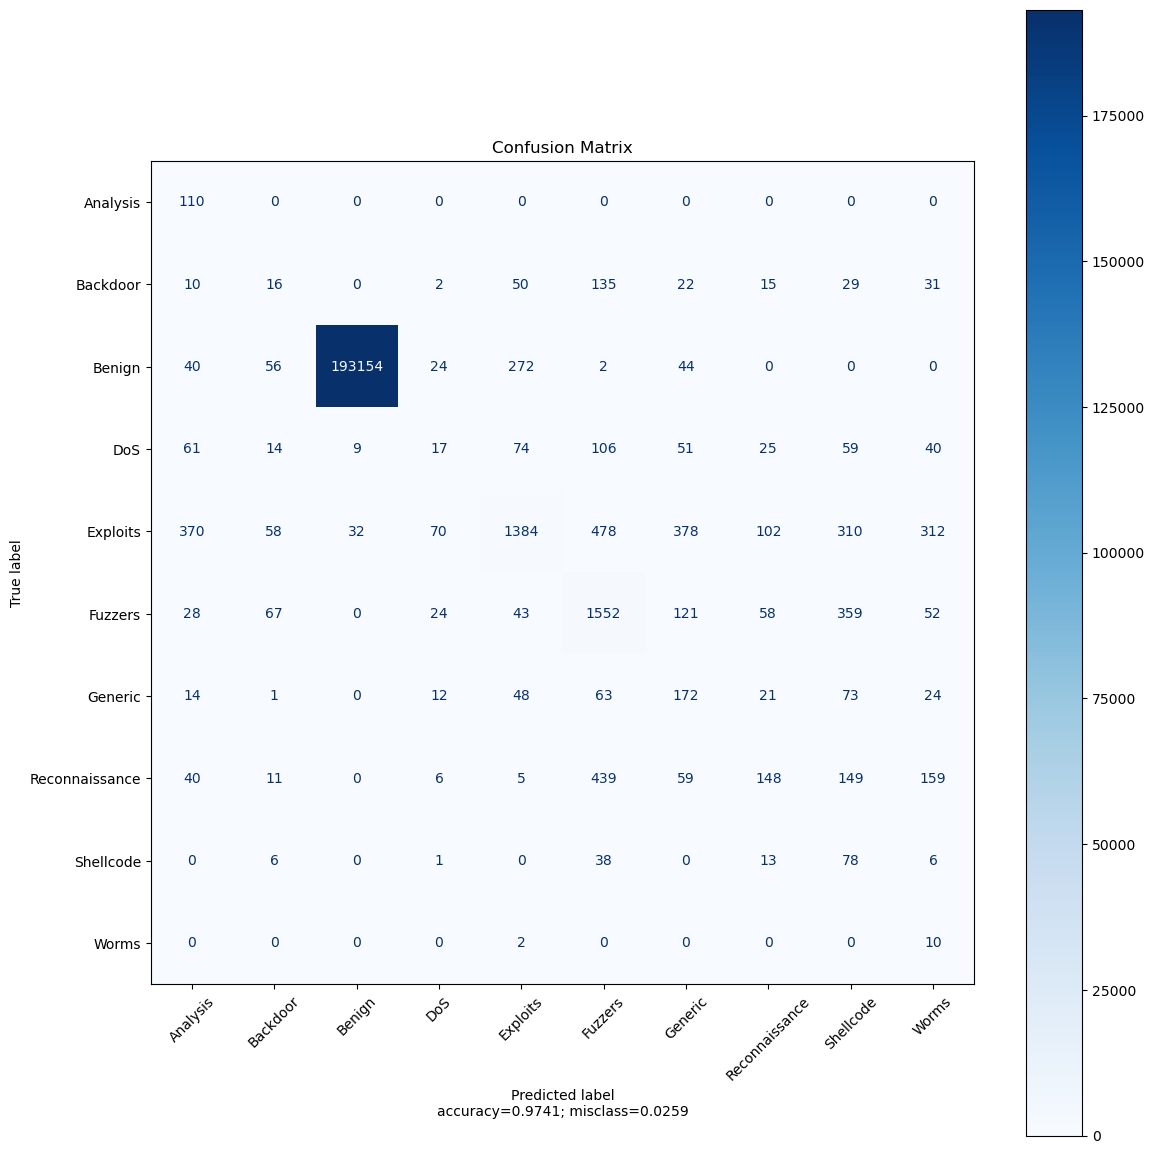

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(actual, test_pred)
labels = np.unique(actual)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap=plt.get_cmap('Blues'), colorbar=True)
plt.title("Confusion Matrix")
plt.xlabel(f'Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}')
plt.ylabel('True label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()